<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset_DeepSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 
num_classes = 7
#df_train

In [6]:
#decode one hot label
df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

#drop one-hot column
df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

#make filepaths of the image
dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'

Label Distribution

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

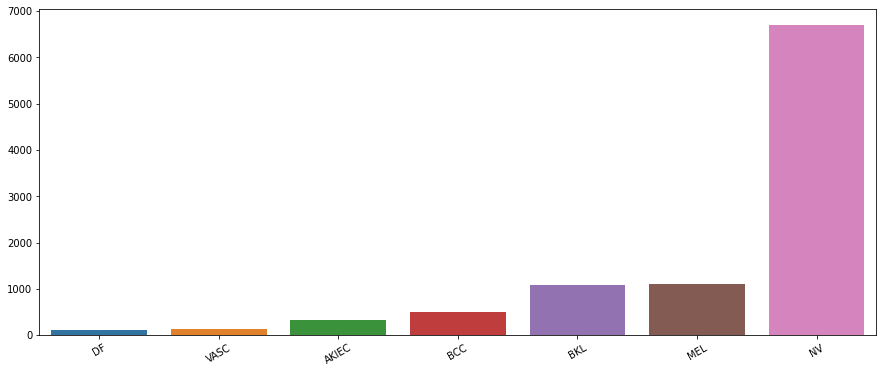

In [7]:
# ordered count of rows per unique label
labels_count = df_train['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [8]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df_train['Labels'].unique())
#for label in labels:
#    plot_images_per_label(df_train, label, 3, (12,9))

Drop duplicate images

In [9]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])


Manual undersampling majority class

In [10]:
df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=.6).index)

Prepare X,y

In [11]:
# input image size
IMAGE_W = 56
IMAGE_H = 56
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [12]:
#TIME CONSUMING OPERATION
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#X = []
#for img in df['FilePaths']:
    #img_arr = load_img(img, target_size=IMG_SIZE)
#    with load_img(img, target_size=IMG_SIZE) as img_arr:
#      X.append(img_to_array(img_arr))

#X = np.array(X)
df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [13]:
X_train = np.asarray(df_train['image_px'].tolist())
X_val = np.asarray(df_val['image_px'].tolist())
print(np.array(X_train).shape)
print(np.array(X_val).shape)

(5992, 56, 56, 3)
(193, 56, 56, 3)


In [14]:
y_train = np.array(df_train['Labels'].values)

# summarize class distribution
from collections import Counter
counter = Counter(y_train)
print(counter)
print(y_train.shape)

Counter({'NV': 2682, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327, 'VASC': 142, 'DF': 115})
(5992,)


In [15]:
y_val = np.array(df_val['Labels'].values)
print(Counter(y_val))
print(y_val.shape)

Counter({'NV': 123, 'BKL': 22, 'MEL': 21, 'BCC': 15, 'AKIEC': 8, 'VASC': 3, 'DF': 1})
(193,)


In [16]:
#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_train

array([5, 5, 4, ..., 4, 4, 2])

#SMOTE Oversampling

In [ ]:
def SMOTE_Data(X, y):
  sm = SMOTE(random_state=42, k_neighbors=5)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
  X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
  return X_resampled, y_resampled

In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X_train.shape)
print(y_train.shape)

(32851, 150528)
(32851,)


In [ ]:
counter = Counter(y_train)
print(counter)

Counter({5: 4693, 4: 4693, 2: 4693, 3: 4693, 0: 4693, 1: 4693, 6: 4693})


In [ ]:
X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
print('X_train shape: ',X_train.shape)

X_train shape:  (32851, 224, 224, 3)


#DeepSMOTE Oversampling

In [17]:
#Normalization
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_train = (X_train - X_train_mean)/X_train_std
X_val = (X_val - X_train_mean)/X_train_std

In [18]:
#optional
#X=X_train
#y=y_train

from numpy import moveaxis
X_train = moveaxis(X_train, 3, 1)
#X_train = X_train.astype('float32') / 255.
#dec_x = X_train 
#dec_y = y

#create counter for encoder
counter = sorted(counter.items())
counter = [value for _, value in counter]

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.neighbors import NearestNeighbors
import time
import os

print(torch.version.cuda) #10.1

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 

args['n_z'] = 600 #300     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 300       # how many epochs to run for
args['batch_size'] = 12   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['patience'] = 20

## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        #[(W−K+2P)/S]+1.
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),# 224 > 112
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),# > 56
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),# > 28
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 7, 2, 0, bias=False),# > 14
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            nn.LeakyReLU(0.2, inplace=True))
#            nn.Conv2d(self.dim_h * 8, self.dim_h * 16, 7, 2, 0, bias=False),# > 7
#            nn.BatchNorm2d(self.dim_h * 16), # 40 X 8 = 320
#            nn.LeakyReLU(0.2, inplace=True))
#            nn.Conv2d(self.dim_h * 16, self.dim_h * 32, 7, 2, 0, bias=False),# > 1
#            nn.BatchNorm2d(self.dim_h * 32), # 40 X 8 = 320
#            nn.LeakyReLU(0.2, inplace=True))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**3 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        #H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
#            nn.ConvTranspose2d(self.dim_h * 32, self.dim_h * 16, 4, 2, 1), # > 14 > 28 > 56 > 112 > 224
#            nn.BatchNorm2d(self.dim_h * 16),
#            nn.ReLU(True),
#            nn.ConvTranspose2d(self.dim_h * 16, self.dim_h * 8, 4, 2, 1), # > 28
#            nn.BatchNorm2d(self.dim_h * 8),
#            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4, 2, 1),# > 56
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4, 2, 1),# > 112
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 3, 4, 2, 1),# > 224
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**3, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

11.3


In [40]:
#Begin the training
batch_size = args['batch_size']
patience = args['patience']
encoder = Encoder(args)
decoder = Decoder(args)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
decoder = decoder.to(device)
encoder = encoder.to(device)

train_on_gpu = torch.cuda.is_available()

#decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

num_workers = 0

#torch.Tensor returns float so if want long then use torch.tensor
tensor_x = torch.Tensor(X_train)
tensor_y = torch.tensor(y_train,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, 
    batch_size=batch_size,shuffle=True,num_workers=num_workers)

best_loss = np.inf

t0 = time.time()
if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    for epoch in range(args['epochs']):
        train_loss = 0.0
        tmse_loss = 0.0
        tdiscr_loss = 0.0
        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
    
        for images,labs in train_loader:
        
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            images, labs = images.to(device), labs.to(device)
            labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
            # run images
            z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
        
            x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
            mse = criterion(x_hat,images)
                    
            resx = []
            resy = []
        
            tc = np.random.choice(num_classes,1)
            #tc = 9
            xbeg = X_train[y_train == tc]
            ybeg = y_train[y_train == tc] 
            xlen = len(xbeg)
            nsamp = min(xlen, 100)
            ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
            xclass = xbeg[ind]
            yclass = ybeg[ind]
        
            xclen = len(xclass)
            xcminus = np.arange(1,xclen)
            
            xcplus = np.append(xcminus,0)
            xcnew = (xclass[[xcplus],:])
            xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
        
            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
        
            #encode xclass to feature space
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
        
            xclass = xclass.detach().cpu().numpy()
        
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
        
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            
            ximg = decoder(xc_enc)
            
            mse2 = criterion(ximg,xcnew)
        
            comb_loss = mse2 + mse
            comb_loss.backward()
        
            enc_optim.step()
            dec_optim.step()
        
            train_loss += comb_loss.item()*images.size(0)
            tmse_loss += mse.item()*images.size(0)
            tdiscr_loss += mse2.item()*images.size(0)

        train_loss = train_loss/len(train_loader)
        tmse_loss = tmse_loss/len(train_loader)
        tdiscr_loss = tdiscr_loss/len(train_loader)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                train_loss,tmse_loss,tdiscr_loss))
        
    
    
        #store the best encoder and decoder models
        #here, /crs5 is a reference to 5 way cross validation, but is not
        #necessary for illustration purposes
        if train_loss < best_loss:
            print('Saving..')
            patience = args['patience']
            path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_enc.pth'
            path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_dec.pth'
          
            torch.save(encoder.state_dict(), path_enc)
            torch.save(decoder.state_dict(), path_dec)
    
            best_loss = train_loss
        else:
            patience = patience - 1

        if patience == 0:
            print('Out of patience. \n')
            break
    
    
    #in addition, store the final model (may not be the best) for
    #informational purposes
    path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_enc.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_dec.pth'
    print(path_enc)
    print(path_dec)
    torch.save(encoder.state_dict(), path_enc)
    torch.save(decoder.state_dict(), path_dec)

cuda
Epoch: 0 	Train Loss: 7.299708 	mse loss: 3.948752 	mse2 loss: 3.350956
Saving..
Epoch: 1 	Train Loss: 5.475280 	mse loss: 3.023897 	mse2 loss: 2.451383
Saving..
Epoch: 2 	Train Loss: 4.937226 	mse loss: 2.787710 	mse2 loss: 2.149516
Saving..
Epoch: 3 	Train Loss: 4.739900 	mse loss: 2.696243 	mse2 loss: 2.043657
Saving..
Epoch: 4 	Train Loss: 4.545835 	mse loss: 2.640414 	mse2 loss: 1.905420
Saving..
Epoch: 5 	Train Loss: 4.546779 	mse loss: 2.591076 	mse2 loss: 1.955702
Epoch: 6 	Train Loss: 4.416031 	mse loss: 2.550796 	mse2 loss: 1.865234
Saving..
Epoch: 7 	Train Loss: 4.367793 	mse loss: 2.514564 	mse2 loss: 1.853230
Saving..
Epoch: 8 	Train Loss: 4.426613 	mse loss: 2.502036 	mse2 loss: 1.924577
Epoch: 9 	Train Loss: 4.300451 	mse loss: 2.479648 	mse2 loss: 1.820803
Saving..
Epoch: 10 	Train Loss: 4.274477 	mse loss: 2.465263 	mse2 loss: 1.809215
Saving..
Epoch: 11 	Train Loss: 4.314148 	mse loss: 2.447080 	mse2 loss: 1.867068
Epoch: 12 	Train Loss: 4.204870 	mse loss: 2.432

In [20]:
#Generate artificial images
import torch
np.printoptions(precision=5,suppress=True)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/'

encf = []
decf = []
for p in range(1):
    enc = modpth + '/bst_enc.pth'
    dec = modpth + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)

for m in range(1):
    print('train imgs shape ',X_train.shape) #(45000,3,32,32)
    print('decy ',y_train.shape)
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    resx = []
    resy = []

    for i in [0,1,2,3,4,6]: #skip class 5 since it's max class
        torch.cuda.empty_cache()

        xclass, yclass = biased_get_class(X_train, y_train, i)
#        print(xclass.shape) #(500, 3, 32, 32)
#        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
            
        xclass = xclass.detach().cpu().numpy()
        n = np.max(counter) - counter[i]
        xsamp, ysamp = G_SM(xclass,yclass,n,i)
#        print(xsamp.shape) #(4500, 600)
#        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
#        print(ximn.shape) 
        resx.append(ximn)
        resy.append(ysamp)
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
#    print(resx1.shape) #(34720, 3, 32, 32)

    resx1 = resx1.reshape(resx1.shape[0],-1)
#    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = X_train.reshape(X_train.shape[0],-1)
#    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,y_train))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)
#    print()

train imgs shape  (5992, 3, 56, 56)
decy  (5992,)
(18774, 9408)
(18774,)


In [21]:
X_train = combx.reshape(-1, 3, IMAGE_W, IMAGE_H)
X_train = moveaxis(X_train, 1, 3)
print('X_train shape: ',X_train.shape)
y_train = comby
print(Counter(comby))

X_train shape:  (18774, 56, 56, 3)
Counter({0: 2682, 1: 2682, 2: 2682, 3: 2682, 4: 2682, 6: 2682, 5: 2682})


In [ ]:
#X_train = X_train * 255
#X_train = X_train.astype(int)

In [22]:
#de-standardization
X_train = (X_train * X_train_std + X_train_mean).astype(int)
X_val = (X_val * X_train_std + X_train_mean).astype(int)

#Data Transformation

In [23]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('y_train shape: ',y_train.shape)

y_train shape:  (18774, 1)


In [24]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)

In [25]:
#X_val = X_val.astype(int)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(18774, 56, 56, 3)
(18774, 7)
(193, 56, 56, 3)
(193, 7)


#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (9814, 32, 32, 3)
Remaining Data:  (201, 32, 32, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


Create and compile the model

In [ ]:
print(X_train)

In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

# Classification
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [27]:
#USe TF.data
import tensorflow as tf
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [28]:
autotune = tf.data.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=40000).batch(32).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)

In [29]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

In [30]:
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

EPOCHS = 1000
BATCH_SIZE = 32

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_DeepSMOTE.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_DeepSMOTE.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_prc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=30,monitor='val_prc')

In [31]:
from tensorflow import keras
# this could also be the output a different Keras model or layer
input_shape = X_train.shape[1:]
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
x = data_augmentation(input_tensor)
#x = rescale_layer(x)

base_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
x = base_model(x)


# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
#x = Dropout(0.2)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)
#predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=input_tensor, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
#hst = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', keras.metrics.AUC(name='prc', curve='PR')])
#hst = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
hst = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/1000
587/587 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.5204 - prc: 0.5734
Epoch 1: val_prc improved from -inf to 0.83135, saving model to /content/drive/MyDrive/PHD/Model/best_model_DeepSMOTE.h5
587/587 [==============================] - 22s 27ms/step - loss: 1.2731 - accuracy: 0.5204 - prc: 0.5734 - val_loss: 0.7218 - val_accuracy: 0.6891 - val_prc: 0.8314 - lr: 5.0000e-04
Epoch 2/1000
587/587 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.5871 - prc: 0.6620
Epoch 2: val_prc did not improve from 0.83135
587/587 [==============================] - 11s 19ms/step - loss: 1.0813 - accuracy: 0.5871 - prc: 0.6620 - val_loss: 0.7416 - val_accuracy: 0.7306 - val_prc: 0.8164 - lr: 5.0000e-04
Epoch 3/1000
586/587 [============================>.] - ETA: 0s - loss: 1.0219 - accuracy: 0.6094 - prc: 0.6906
Epoch 3: val_prc did not improve from 0.83135
587/587 [=============

In [ ]:
# load the saved model
#best_model = load_model(best_model_fpath)
# evaluate the model
#_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
#_, test_acc = best_model.evaluate(X_val, y_val, verbose=0)
#print('Train: %.3f, Val: %.3f' % (train_acc, test_acc))

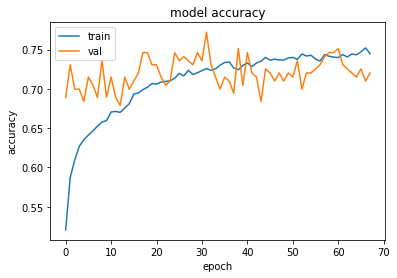

In [32]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Fine Tune

In [ ]:
#finetune_model_fpath = '/content/drive/MyDrive/PHD/Model/finetune_model.h5'
#mc_finetune = ModelCheckpoint(finetune_model_fpath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [39]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
#model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#hst2 = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', keras.metrics.AUC(name='prc', curve='PR')])
#hst2 = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
 #                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


Epoch 1/1000
585/587 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.7467 - prc: 0.8471
Epoch 1: val_prc did not improve from 0.84590
587/587 [==============================] - 15s 20ms/step - loss: 0.6658 - accuracy: 0.7466 - prc: 0.8470 - val_loss: 0.7658 - val_accuracy: 0.7202 - val_prc: 0.8142 - lr: 1.5625e-05
Epoch 2/1000
586/587 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.7428 - prc: 0.8460
Epoch 2: val_prc did not improve from 0.84590
587/587 [==============================] - 11s 19ms/step - loss: 0.6687 - accuracy: 0.7428 - prc: 0.8460 - val_loss: 0.7658 - val_accuracy: 0.7202 - val_prc: 0.8142 - lr: 1.5625e-05
Epoch 3/1000
586/587 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.7481 - prc: 0.8471
Epoch 3: val_prc did not improve from 0.84590
587/587 [==============================] - 12s 20ms/step - loss: 0.6606 - accuracy: 0.7482 - prc: 0.8472 - val_loss: 0.7658 - val_accuracy: 0.7202 - val_prc: 0.81

In [34]:
#save last model

model.save(last_model_fpath)

In [40]:
last_model = load_model(last_model_fpath)
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

balanced accuracy on training 0.6735378715244487
balanced accuracy on validation 0.4477302894550282
Score on val data:  (0.5095860566448802, 0.4477302894550282, 0.44639760895918534, None)


In [ ]:
best_model = load_model(best_model_fpath)
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['accuracy'])
plt.plot(hst2.history['val_accuracy'])
plt.title('model accuracy after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Testing
Result from ISIC Live
last_model: 0.506
best_model: 0.478

In [47]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [48]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

In [49]:
df_test['image'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [50]:
X_test = np.asarray(df_test['image'].tolist())
print(np.array(X_test).shape)

(1512, 56, 56, 3)


Calculate y_pred from training and testing for analysis

In [51]:
# predicted labels
Y_pred2 = last_model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

InternalError: ignored

In [ ]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]

In [ ]:
df_pred.set_index("image", inplace = True)
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_DeepSMOTEOversampling_last.csv')

#Confusion Metric on Validation Set

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

print(cf_matrix)

In [ ]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In [ ]:
# ordered count of rows per unique label
labels_count = df_val['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)